# Prostate Cancer

In this notebook, we use blocked Gibbs sampling to examine the relationship between a prostate specific antigen and cancer volume.

In [1]:
import collections
import copy
import functools
from typing import Callable, NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import prostate
from stat570.linear_model import linear_regression
from stat570.mcmc import gibbs_sampling

np.set_printoptions(suppress=True)

prostate_data = prostate.load_data()
prostate_data.head()

/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.430783
1,-0.994252,3.319626,58.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.162519
2,-0.510826,2.691243,74.0,-1.386294,0.0,-1.386294,7.0,20.0,-0.162519
3,-1.203973,3.282789,58.0,-1.386294,0.0,-1.386294,6.0,0.0,-0.162519
4,0.751416,3.432373,62.0,-1.386294,0.0,-1.386294,6.0,0.0,0.371564


## TensorFlow `input_fn`

We carry out our computations in TensorFlow, so we'll convert our data into tensors.

In [2]:
def prostate_input_fn():
    features = prostate_data.to_dict('list')
    labels = features.pop('lpsa')
    return tf.data.Dataset.from_tensors((features, labels))

## Sampling Functions

In Gibbs sampling, we sample from the posterior conditional distributions. The inverse error variance (also known as precision) is gamma-distributed, and the coefficients are normally distributed. It's *blocked* Gibbs sampling since we draw both coefficients at once.

In [3]:
def make_inverse_error_variance_dist(
    prior_concentration, prior_rate, features, labels, beta):
    """Makes the the posterior distribution for inverse error variance."""
    with tf.name_scope('make_inverse_error_variance_dist', 
                       values=[
                           prior_concentration,
                           prior_rate,
                           features,
                           labels,
                           beta,
                       ]):
        posterior_concentration = (
            prior_concentration +
            tf.divide(tf.cast(tf.shape(features)[0], tf.float32), 2.))
        posterior_rate = (prior_rate +
                          tf.nn.l2_loss(labels - tf.tensordot(features, beta, 1)))
        
        return tf.distributions.Gamma(
            concentration=posterior_concentration, rate=posterior_rate,
            name='posterior_inverse_error_variance')
    
def make_beta_dist(prior_mean, prior_variance, features, labels, inverse_error_variance):
    """Makes the posterior distribution for model coefficients."""
    shape = int(prior_mean.shape[0])
    with tf.name_scope('make_beta_dist',
                       values=[
                           inverse_error_variance,
                           features,
                           labels,
                           prior_mean,
                           prior_variance,
                       ]):
        transposed_features = tf.transpose(features)
        gramian_matrix = tf.matmul(transposed_features, features)
        mle_mean = tf.squeeze(tf.linalg.cholesky_solve(
            tf.linalg.cholesky(gramian_matrix),
            tf.matmul(transposed_features, tf.expand_dims(labels, -1))))
        mle_precision = gramian_matrix*inverse_error_variance            
        
        posterior_precision = mle_precision + tf.eye(shape)/prior_variance
        posterior_covariance = tf.linalg.cholesky_solve(
            tf.linalg.cholesky(posterior_precision), tf.eye(shape))
        
        posterior_mean = tf.tensordot(
            tf.matmul(posterior_covariance, mle_precision),
            mle_mean - prior_mean, axes=1) + prior_mean
        
        return tfp.distributions.MultivariateNormalFullCovariance(
            loc=posterior_mean, covariance_matrix=posterior_covariance,
            name='posterior_beta')

## Model

Now, we specify the model. The generative process is specified in `forward`. We build our conditional disributions based on the data and use them to construct the transition kernel for Markov Chain Monte Carlo (MCMC) sampling.

The code for [`gibbs_sampling.GibbsSamplingKernel`](https://github.com/ppham27/stat570/blob/master/stat570/mcmc/gibbs_sampling.py) can be on my [GitHub](https://github.com/ppham27/stat570/blob/master/stat570/mcmc/gibbs_sampling.py).

In [4]:
def model_fn(features, labels, mode, params, config):
    del config
    
    prior_inverse_error_variance_concentration = (
        params['prior']['inverse_error_variance']['concentration'])
    prior_inverse_error_variance_rate = (
        params['prior']['inverse_error_variance']['rate'])
        
    prior_beta_mean = tf.constant(params['prior']['beta']['mean'],
                                  dtype=tf.float32)
    prior_beta_variance = tf.constant(params['prior']['beta']['variance'],
                                      dtype=tf.float32)
    
    def forward(features):
        inverse_error_variance = tfp.edward2.Gamma(
            concentration=prior_inverse_error_variance_concentration,
            rate=prior_inverse_error_variance_rate,
            name='inverse_error_variance')
    
        beta = tfp.edward2.MultivariateNormalDiag(
            loc=prior_beta_mean,
            scale_identity_multiplier=tf.sqrt(prior_beta_variance), name='beta')
        
        return tfp.edward2.Normal(
            loc=tf.tensordot(features, beta, axes=1), scale=1/tf.sqrt(inverse_error_variance),
            name='labels')
    
    features = tf.feature_column.input_layer(
        features, [tf.feature_column.numeric_column('lcavol')])
    features = tf.concat((tf.ones_like(features), features), axis=-1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return forward(features).value
    
    log_joint_fn = functools.partial(
        tfp.edward2.make_log_joint_fn(lambda: forward(features)),
        labels=labels)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return log_joint_fn(labels=labels) # currently will error
    
    samplers = [
        functools.partial(
            make_inverse_error_variance_dist,
            prior_inverse_error_variance_concentration,
            prior_inverse_error_variance_rate,
            features, labels),
        functools.partial(
            make_beta_dist, prior_beta_mean, prior_beta_variance, features, labels),
    ]
        
    kernel = tfp.mcmc.MetropolisHastings(
        inner_kernel=gibbs_sampling.GibbsSamplingKernel(
            samplers=samplers,
            target_log_prob_fn=lambda inverse_error_variance, beta: log_joint_fn(
                inverse_error_variance=inverse_error_variance,
                beta=beta)))
    
    samples, _ = tfp.mcmc.sample_chain(
        num_results=params['mcmc']['num_results'],
        current_state=(
            tf.convert_to_tensor(
                params['mcmc']['initial_state']['inverse_error_variance'], tf.float32),
            tf.convert_to_tensor(
                params['mcmc']['initial_state']['beta'], tf.float32)),
        kernel=kernel,
        num_burnin_steps=params['mcmc']['num_burnin_steps'],
        num_steps_between_results=len(samplers) - 1,
        parallel_iterations=1)
    
    return samples

## Running MCMC

Prior parameters are taken from the homework. A gamma distribution with $0$ shape and $0$ rate is improper so very small values were used.

In [5]:
_DEFAULT_PARAMS = {
    'prior': {
        'inverse_error_variance': {
            'concentration': 0.1,  # Also called shape and denoted alpha
            'rate': 0.1,  # Usually denoted by beta.
        },
        'beta': {
            'mean': [0., 0.],
            'variance': 2.,  # Enforce equal variance and no covariance.
        },
    },
    'mcmc': {
        'num_burnin_steps': 0,
        'num_results': 128,
        'initial_state': {
            'inverse_error_variance': 1.,
            'beta': [0., 0.],
        },
    },
}

def get_mle_params():
    mle_params = copy.deepcopy(_DEFAULT_PARAMS)
    mle_model = linear_regression.LinearRegression.from_data_frame(
        prostate_data, ['lcavol'], 'lpsa')
    mle_params['mcmc']['initial_state']['inverse_error_variance'] = (
        1./mle_model.residual_variance_)
    mle_params['mcmc']['initial_state']['beta'] = mle_model.coefficients_['estimate'].values
    return mle_params

def get_prior_params(params=_DEFAULT_PARAMS):
    prior_params = copy.deepcopy(params)
    prior_params['mcmc']['initial_state']['inverse_error_variance'] = stats.gamma.rvs(
        params['prior']['inverse_error_variance']['concentration'],
        scale=1/params['prior']['inverse_error_variance']['rate'])
    prior_params['mcmc']['initial_state']['beta'] = stats.multivariate_normal.rvs(
        mean=params['prior']['beta']['mean'],
        cov=params['prior']['beta']['variance']*np.eye(len(params['prior']['beta']['mean'])))
    return prior_params

### TensorFlow

We start a TensorFlow session to run the two chains.

In [6]:
def run_chains(params_dict):
    graph = tf.Graph()
    with graph.as_default():
        features, labels = prostate_input_fn().repeat().make_one_shot_iterator().get_next()
        chain_ops = {
            key: model_fn(features, labels, tf.estimator.ModeKeys.TRAIN,
                             params, tf.estimator.RunConfig())
            for key, params in params_dict.items()
        }
        init_op = tf.group(tf.global_variables_initializer())
    graph.finalize()
    
    with graph.as_default(), tf.Session() as sess:
        sess.run(init_op)
        return sess.run(chain_ops)

states = run_chains({'mle': get_mle_params(), 'prior': get_prior_params()})

/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


## Trace Plots

To examine how many burn-in steps are needed, we qualitatively examine when the trace becomes stationary.

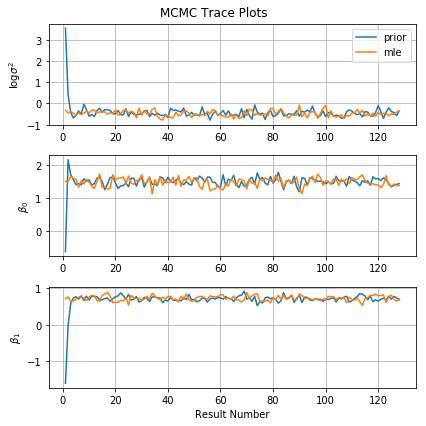

In [7]:
TracePlotOptions = NamedTuple('TracePlotOptions', [
    ('label', str),
    ('transform', Callable[[np.array], np.array]),
])

def plot_traces(states_dict, options, title):
    def plot_trace(ax, states_dict, label):        
        for key, states in states_dict.items():
            ax.plot(np.arange(len(states)) + 1, states, label=key)
        ax.grid(True)
        ax.set_ylabel(label)
        
    states_dict = {
        key: np.hstack([value[:,np.newaxis] if value.ndim == 1 else value for value in values])
        for key, values in states_dict.items()
    }
    assert np.all(
        [value.shape[1] == len(options)
         for value in states_dict.values()]),'Options must be provided for each parameter.'    
    fig, axes = plt.subplots(figsize=(6, 6), nrows=len(options))
    for i, (ax, option) in enumerate(zip(axes, options)):
        plot_trace(
            ax,
            {key: option.transform(value[:,i]) for key, value in states_dict.items()},
            option.label)
    axes[0].legend()
    axes[-1].set_xlabel('Result Number')
    fig.suptitle(title)    
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    return fig

TRACE_PLOT_OPTIONS = [
    TracePlotOptions(label='$\\log\\sigma^2$', transform=lambda x: np.log(1/x)),
    TracePlotOptions(label='$\\beta_0$', transform=lambda x: x),
    TracePlotOptions(label='$\\beta_1$', transform=lambda x: x),
]

fig = plot_traces(states, TRACE_PLOT_OPTIONS, 'MCMC Trace Plots')
fig.savefig('p1_trace.pdf', bbox_inches='tight')

## Running Full Chain

Not much burn-in is needed, so we can run the full chain now.

In [8]:
def merge_params(params, updates):
    for k, v in updates.items():
        if isinstance(v, collections.Mapping):
            params[k] = merge_params(params.get(k, {}), v)
        else:
            params[k] = v
    return params

_MCMC_PARAMS = {
    'mcmc': {
        'num_results': 2048,
        'num_burnin_steps': 128,
    },
}

states = run_chains({
    'mle': merge_params(get_mle_params(), _MCMC_PARAMS),
    'prior': merge_params(get_prior_params(), _MCMC_PARAMS),
})

/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


In [9]:
states_data_frame = pd.DataFrame(collections.OrderedDict([
    ('$\\sigma$', np.sqrt(1/np.concatenate([v[0] for v in states.values()]))),
    ('$\\beta_0$', np.concatenate([v[1][:,0] for v in states.values()])),
    ('$\\beta_1$', np.concatenate([v[1][:,1] for v in states.values()]))
]))

In [10]:
states_summary = pd.DataFrame(collections.OrderedDict([
    ('Posterior mean', states_data_frame.mean()),
    ('Standard deviation', states_data_frame.std(ddof=1)),
    ('10% quantile', states_data_frame.quantile(.1)),
    ('50% quantile', states_data_frame.quantile(.5)),
    ('90% quantile', states_data_frame.quantile(.9)),
]))

with open('p1_summary.tex', 'w') as f:
    f.write(states_summary.to_latex(escape=False).replace('%', '\\%'))

states_summary

,Posterior mean,Standard deviation,10% quantile,50% quantile,90% quantile
$\sigma$,0.796154,0.056701,0.726527,0.793442,0.871269
$\beta_0$,1.495039,0.120843,1.341545,1.494805,1.652094
$\beta_1$,0.723290,0.068159,0.638009,0.724150,0.808873


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

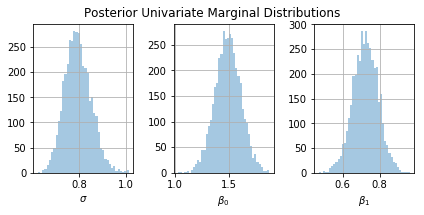

In [11]:
fig, axes = plt.subplots(figsize=(6,3), ncols=len(states_data_frame.columns))
for ax, (column_name, samples) in zip(axes, states_data_frame.items()):
    sns.distplot(samples, kde=False, ax=ax)
    ax.grid(True)
fig.suptitle('Posterior Univariate Marginal Distributions')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.savefig('p1_univariate_marginals.pdf', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

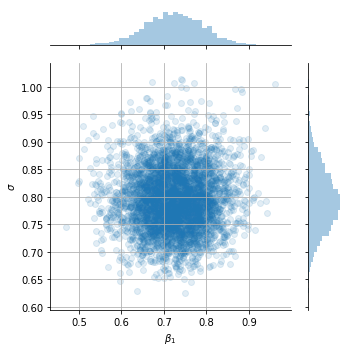

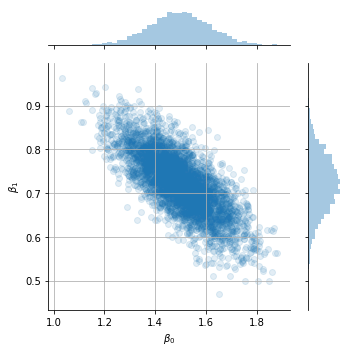

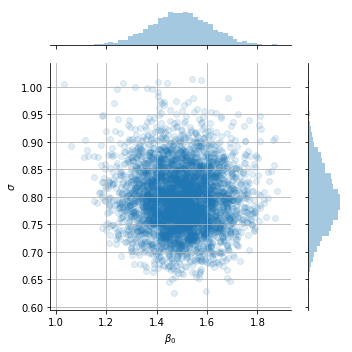

In [12]:
_BIVARIATE_PAIRS = {
    'beta0_beta1': ('$\\beta_0$', '$\\beta_1$'),
    'beta0_sigma': ('$\\beta_0$', '$\\sigma$'),
    'beta1_sigma': ('$\\beta_1$', '$\\sigma$'),
}

for label, (x, y) in _BIVARIATE_PAIRS.items():
    joint_grid = sns.jointplot(x, y, data=states_data_frame, alpha=1/8)
    joint_grid.ax_joint.grid(True)
    joint_grid.fig.set_figwidth(5)
    joint_grid.fig.set_figheight(5)
    joint_grid.fig.tight_layout()
    joint_grid.fig.savefig('p1_{}.pdf'.format(label), bbox_inches='tight')

## Empirical Estimate for $\mathbb{P}\left(\beta_1 > 0.5\right)$

We can estimate how significant the relationship between the prostate specific antigen and cancer volume by computing the emprical estimate for probability that the coefficient is greater than $0.5$.

In [13]:
np.mean(states_data_frame['$\\beta_1$'] > 0.5)

0.9990234375